In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

import h5py
import sys
sys.path.append('../')
import analysis_utils as utils

from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.signal import decimate

yale_colors = ['#00356b', '#286dc0', '#63aaff', '#4a4a4a']
utils.load_plotting_setting()

from matplotlib.gridspec import GridSpec
from matplotlib.ticker import LogLocator, NullFormatter, MultipleLocator

In [2]:
c_mv = 8.263269630174246e-08
amp2kev = 7157.624533259538

## Make a nice figure

/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_20472/1292840068.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


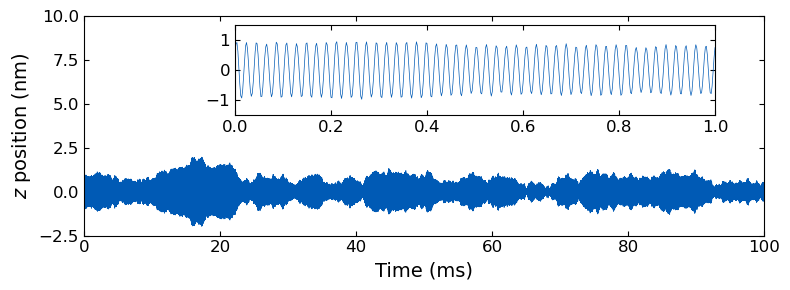

In [28]:
window_length = 5000
f = h5py.File('/Volumes/LaCie/dm_data/sphere_20250103/20250111_1e-8mbar_8e_alignment1_long/20250111_d_17.hdf5', 'r')

dtt = f['data'].attrs['delta_t']
fs = int(np.ceil(1 / dtt))   # Sampling rate at Hz
zz = f['data']['channel_d'][:] * f['data']['channel_d'].attrs['adc2mv'] / 1e3  # Signal in V

zz_bp = utils.bandpass_filtered(zz, fs, 30000, 80000)

zz_shaped = np.reshape(zz, (int(zz.size / window_length), window_length))
zz_bp_shaped = np.reshape(zz_bp, (int(zz_bp.size / window_length), window_length))

f.close()

fig, ax = plt.subplots(1, 1, figsize=(8, 3))

tt = np.arange(0, zz_bp.size) * 2e-6
ax.plot((tt-20) / 1e-3, zz_bp * c_mv/1e-9, color='#005AB5', linewidth=0.5)

ax.set_xlim(0, 100)
ax.set_ylim(-2.5, 10)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('$z$ position (nm)')

left, bottom, width, height = [0.3, 0.6, 0.6, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])

ax2.plot((tt-20) / 1e-3, zz_bp * c_mv/1e-9, color='#005AB5', linewidth=0.5)
ax2.set_xlim(0, 1)
ax2.set_ylim(-1.5, 1.5)

fig.tight_layout()


In [35]:
from scipy.signal import welch
ff, pp = welch(zz, fs=500000, nperseg=2**11)

Text(0, 0.5, 'Amplitude spectral density (m/$\\sqrt{\\mathrm{Hz}}$)')

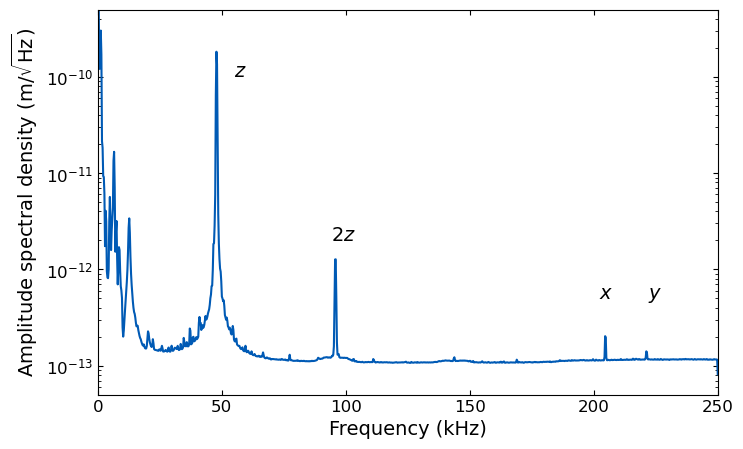

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.plot(ff/1000, np.sqrt(pp)*c_mv, color='#005AB5')
ax.set_yscale('log')
ax.set_xlim(0, 250)
ax.set_ylim(5e-14, 5e-10)

ax.text(55, 1e-10, r'$z$', fontsize=14)
ax.text(94, 2e-12, r'$2z$', fontsize=14)

ax.text(202, 5e-13, r'$x$', fontsize=14)
ax.text(222, 5e-13, r'$y$', fontsize=14)

ax.set_xlabel('Frequency (kHz)')
ax.set_ylabel(r'Amplitude spectral density (m/$\sqrt{\mathrm{Hz}}$)')


## Example events rejected by each data cut

In [438]:
f = h5py.File('/Volumes/LaCie/dm_data_processed_amp_chisquare/sphere_20250103/20250104_4e-8mbar_alignment0_long/20250104_d_220_processed.hdf5', 'r')
amplitude = f['data_processed']['amplitude'][:]
idx_in_window = f['data_processed']['idx_in_window'][:]
good_detection = f['data_processed']['good_detection'][:]
noise_level_amp = f['data_processed']['noise_level_amp'][:]
chisquare_short = f['data_processed']['chisquare_short'][:]
f.close()

f = h5py.File('/Volumes/LaCie/dm_data_processed_fullamp/sphere_20250103/20250104_4e-8mbar_alignment0_long/20250104_d_220_processed.hdf5', 'r')
fullamp = f['data_processed']['amplitude'][:]
f.close()

window_length = 5000
f = h5py.File('/Volumes/LaCie/dm_data/sphere_20250103/20250104_4e-8mbar_alignment0_long/20250104_d_220.hdf5', 'r')

dtt = f['data'].attrs['delta_t']
fs = int(np.ceil(1 / dtt))   # Sampling rate at Hz
zz = f['data']['channel_d'][:] * f['data']['channel_d'].attrs['adc2mv'] / 1e3  # Signal in V

zz_bp = utils.bandpass_filtered(zz, fs, 30000, 80000)

zz_shaped = np.reshape(zz, (int(zz.size / window_length), window_length))
zz_bp_shaped = np.reshape(zz_bp, (int(zz_bp.size / window_length), window_length))

f.close()

#### Detection quality examples

<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_5882/2795621911.py:16: SyntaxWarning: invalid escape sequence '\m'
  axes[0].set_xlabel('Time ($\mu$s)')
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_5882/2795621911.py:17: SyntaxWarning: invalid escape sequence '\m'
  axes[1].set_xlabel('Time ($\mu$s)')


Text(0.5, 0.98, 'Detection quality cut (20250104_4e-8mbar_alignment0_long)')

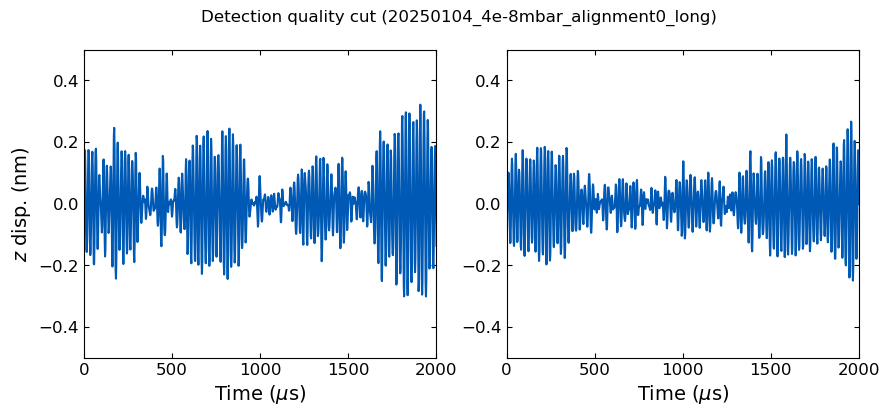

In [15]:
bad_window_idx = np.nonzero(~good_detection)[0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

tt0 = np.arange(0, window_length) * dtt / 1e-6 - 400
axes[0].plot(tt0, zz_bp_shaped[bad_window_idx[4]] * c_mv / 1e-9, color='#005AB5')
axes[0].set_ylim(-0.5, 0.5)
axes[0].set_xlim(0, 2000)

tt1 = np.arange(0, window_length) * dtt / 1e-6 - 5000
axes[1].plot(tt1, zz_bp_shaped[bad_window_idx[8]] * c_mv / 1e-9, color='#005AB5')
axes[1].set_ylim(-0.5, 0.5)
axes[1].set_xlim(0, 2000)

axes[0].set_ylabel('$z$ disp. (nm)')
axes[0].set_xlabel('Time ($\mu$s)')
axes[1].set_xlabel('Time ($\mu$s)')

fig.suptitle(f'Detection quality cut (20250104_4e-8mbar_alignment0_long)')

#### Noise level examples

<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_5882/39233046.py:16: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Time ($\mu$s)')


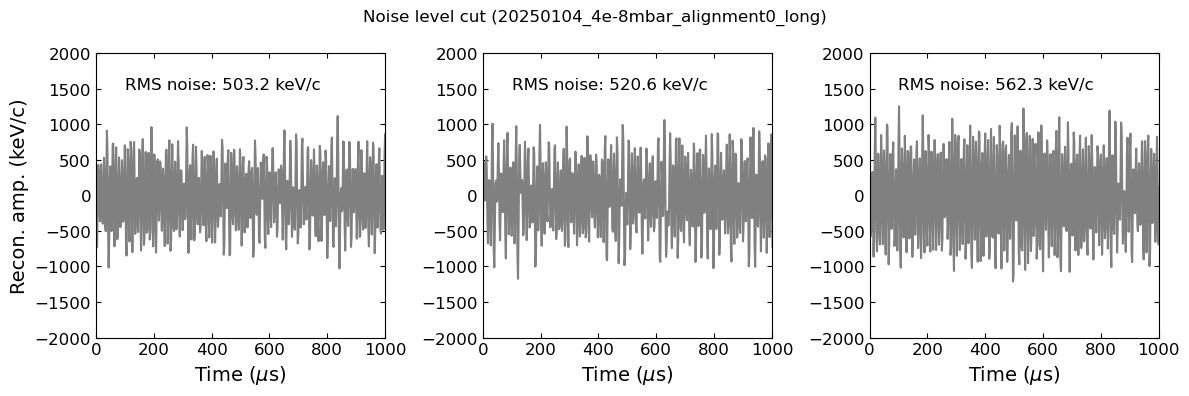

In [16]:
bad_window_idx = np.nonzero(noise_level_amp * amp2kev > 500)[0]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, ax in enumerate(axes):
    tt0 = np.arange(0, window_length) * dtt / 1e-6 - 500
    ax.plot(tt0, fullamp[bad_window_idx[i]] * amp2kev, color='grey')
    ax.text(100, 1500, f'RMS noise: {noise_level_amp[bad_window_idx[i]] * amp2kev:.1f} keV/c', fontsize=12)

# tt1 = np.arange(0, window_length) * dtt / 1e-6 - 500
# axes[1].plot(tt1, fullamp[bad_window_idx[1]] * amp2kev, color='grey')

for ax in axes:
    ax.set_ylim(-2000, 2000)
    ax.set_xlim(0, 1000)
    ax.set_xlabel('Time ($\mu$s)')

axes[0].set_ylabel('Recon. amp. (keV/c)')

fig.suptitle(f'Noise level cut (20250104_4e-8mbar_alignment0_long)')
fig.tight_layout()

Examples of good windows

<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_1988/1845819210.py:13: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Time ($\mu$s)')


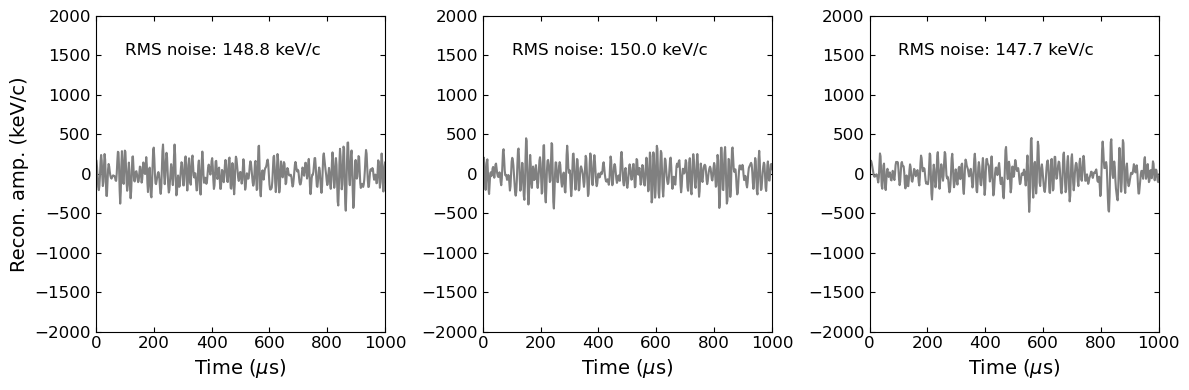

In [324]:
good_window_idx = np.nonzero(noise_level_amp * amp2kev < 150)[0]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, ax in enumerate(axes):
    tt0 = np.arange(0, window_length) * dtt / 1e-6 - 500
    ax.plot(tt0, fullamp[good_window_idx[i]] * amp2kev, color='grey')
    ax.text(100, 1500, f'RMS noise: {noise_level_amp[good_window_idx[i]] * amp2kev:.1f} keV/c', fontsize=12)

for ax in axes:
    ax.set_ylim(-2000, 2000)
    ax.set_xlim(0, 1000)
    ax.set_xlabel('Time ($\mu$s)')

axes[0].set_ylabel('Recon. amp. (keV/c)')

# fig.suptitle(f'Noise level cut (20250104_4e-8mbar_alignment0_long)')
fig.tight_layout()

#### $\chi^2$ cut examples

In [435]:
def get_amp_waveform(amps, amp_indices, bad_amp_idx, length=50):
    amps_window = amps[bad_amp_idx[0]]
    idx_in_window = amp_indices[*bad_amp_idx]
    ret = amps_window[idx_in_window-int(length/2) : idx_in_window+int(length/2)]

    return ret

def get_normalized_template(sphere, voltage, bounds=(1000, 2000), downsampled=False):
    pulse_shape_file = np.load(rf'/Users/yuhan/work/nanospheres/dm_nanospheres/data_processed/pulse_shape/{sphere}_pulse_shape_template_{voltage}v.npz')
    pulse_shapes = pulse_shape_file['pulse_shape']
    pulse_shape_template = np.mean(pulse_shapes, axis=0)

    normalized_template = pulse_shape_template / np.max(pulse_shape_template)

     # Take the central values around the peak
    ret = normalized_template[bounds[0]:bounds[1]]

    # Downsample to 500 kHz (so the 200 us template has 100 indices)
    if downsampled:
        ret_downsampled = decimate(ret, 10)
        return ret_downsampled / np.max(ret_downsampled)
    else:
        return ret

In [440]:
good_noise = (noise_level_amp * amp2kev) < 400
good_det_noise = np.logical_and(good_detection, good_noise)

# Pick out waveforms that pass the detection and noise cut
# chi2 = 400 is for plotting only -- the actual threshold is 150
bad_chi2 = np.asarray(np.nonzero(chisquare_short > 400))

bad_chi2_idx = []
for i, bad_chi2_window in enumerate(bad_chi2[0]):
    if good_det_noise[bad_chi2_window]:
        bad_chi2_idx.append(np.asarray([bad_chi2[0][i], bad_chi2[1][i]]))

bad_chi2_idx = np.asarray(bad_chi2_idx)

<>:9: SyntaxWarning: invalid escape sequence '\c'
<>:9: SyntaxWarning: invalid escape sequence '\c'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_2135/1228089737.py:9: SyntaxWarning: invalid escape sequence '\c'
  ax.text(-40, 1500, f'$\chi^2 = $ {chisquare_short[*bad_chi2_idx[i]]:.1f}')


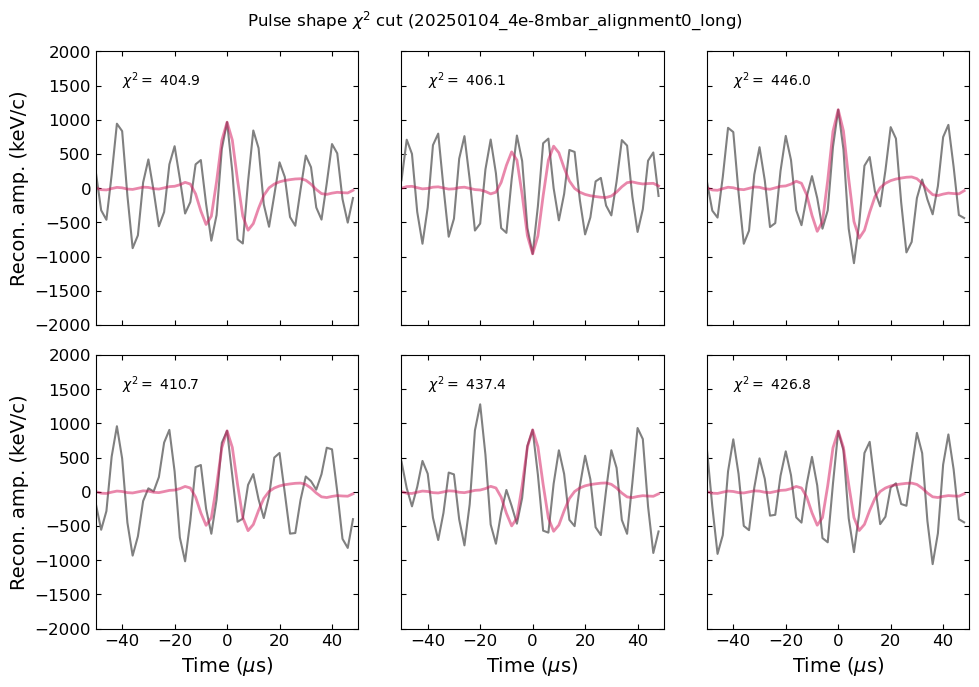

In [441]:
normalized_template_downsampled_short = get_normalized_template('sphere_20250103', voltage=20, bounds=(1250, 1750), downsampled=True)

fig, axes = plt.subplots(2, 3, figsize=(10, 7))

for i, ax in enumerate(axes.flatten()):
    tt0 = np.arange(0, 50) * dtt / 1e-6 - 50
    bad_waveform0 = get_amp_waveform(fullamp, idx_in_window, bad_chi2_idx[i], length=50)

    ax.text(-40, 1500, f'$\chi^2 = $ {chisquare_short[*bad_chi2_idx[i]]:.1f}')
    ax.plot(tt0, bad_waveform0 * amp2kev, color='grey')
    ax.plot(tt0, normalized_template_downsampled_short * bad_waveform0[25] * amp2kev, color='#D41159', alpha=0.5, linewidth=2)

for ax in axes.flatten():
    ax.set_ylim(-2000, 2000)
    ax.set_xlim(-50, 50)

for ax in [axes[0, 1], axes[0, 2], axes[1, 1], axes[1, 2]]:
    ax.set_yticklabels([])

for ax in axes[0]:
    ax.set_xticklabels([])

for ax in [axes[0, 0], axes[1, 0]]:
    ax.set_ylabel('Recon. amp. (keV/c)')
for ax in axes[1]:
    ax.set_xlabel(r'Time ($\mu$s)')

fig.suptitle(fr'Pulse shape $\chi^2$ cut (20250104_4e-8mbar_alignment0_long)', y=0.975)
fig.tight_layout()
fig.align_labels()


Many large pulses were rejected by the $\chi^2$ test. Do $\chi^2$ test cut large pulses even when they look like isolated impulses?

In [ ]:
# Find large pulses rejected by the $\chi^2$ test

large_pulse_file_indices = []
for i in range(len(datasets_1)):
    large_pulse_file_idx = []
    for j, hh in enumerate(hhs_det_noise_1[i]):
        if np.sum(hh[bc > 3000]) > 0:
            large_pulse_file_idx.append(j)
    large_pulse_file_indices.append(np.array(large_pulse_file_idx))

print('Large pulse files (Dataset 20250114_1e-8mbar_1e_alignment1_long): ', large_pulse_file_indices[10])

Large pulse files (Dataset 20250114_1e-8mbar_1e_alignment1_long):  [ 231  306  565  607  665  683  733  850  864 1017 1108 1218 1233 1256]


<>:40: SyntaxWarning: invalid escape sequence '\c'
<>:40: SyntaxWarning: invalid escape sequence '\c'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_2135/788120342.py:40: SyntaxWarning: invalid escape sequence '\c'
  ax.text(-0.075, 4000, f'$\chi^2$ = {chi2[idx_window][idx_search_window]:.2f}', fontsize=12)


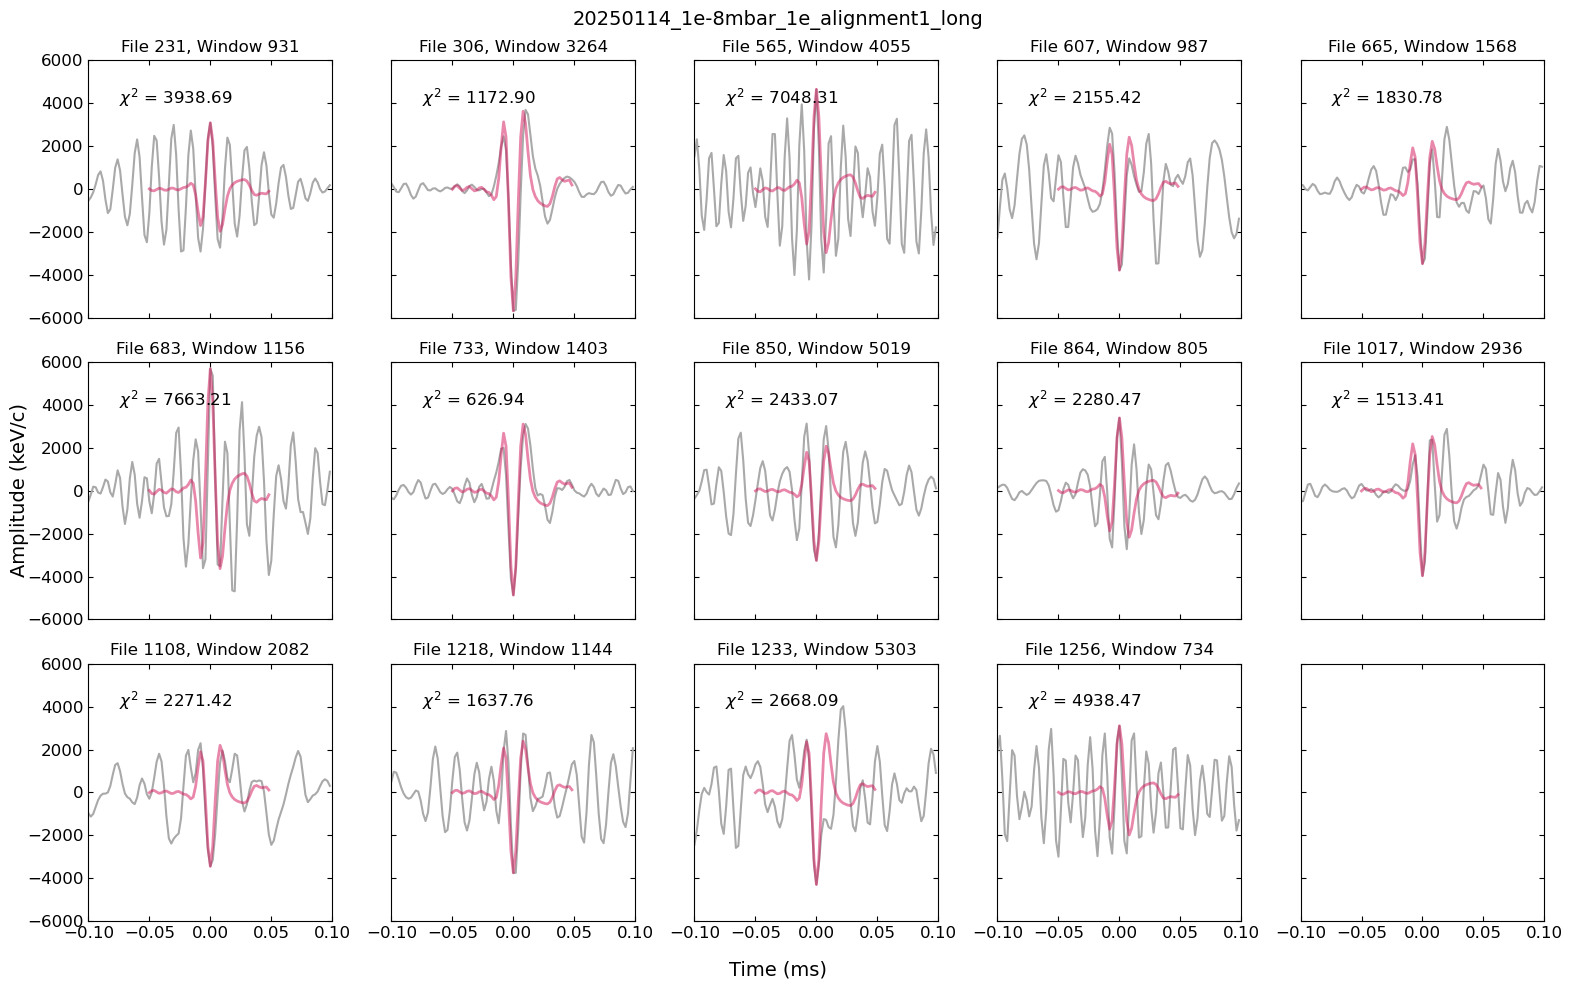

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(16, 10))

normalized_template_downsampled_short = get_normalized_template('sphere_20250103', voltage=20, bounds=(1250, 1750), downsampled=True)

for i, idx_file in enumerate(large_pulse_file_indices[10]):
    ax = axes.flatten()[i]

    file = fr'/Users/yuhan/work/nanospheres/data/dm_data_processed_amp_chisquare/sphere_20250103/20250114_1e-8mbar_1e_alignment1_long/20250114_d_{idx_file}_processed.hdf5'
    f = h5py.File(file, 'r')

    amps = f['data_processed']['amplitude'][:]
    good_detection = f['data_processed']['good_detection'][:]
    noise_level_amp= f['data_processed']['noise_level_amp'][:]
    chi2 = f['data_processed']['chisquare_short'][:]

    f.close()

    idx_window, idx_search_window = np.asarray(np.nonzero(np.abs(amps * amp2kev) > 3000)).T[0]

    window_length = 5000
    f = h5py.File(f'/Users/yuhan/work/nanospheres/data/dm_data/sphere_20250103/20250114_1e-8mbar_1e_alignment1_long/20250114_d_{idx_file}.hdf5', 'r')

    dtt = f['data'].attrs['delta_t']
    fs = int(np.ceil(1 / dtt))   # Sampling rate at Hz
    zz = f['data']['channel_d'][:] * f['data']['channel_d'].attrs['adc2mv'] / 1e3  # Signal in V
    f.close()

    zz_bp = utils.bandpass_filtered(zz, fs, 30000, 80000)
    zz_bp_shaped = np.reshape(zz_bp, (int(zz_bp.size / window_length), window_length))

    _zz_bp = zz_bp_shaped[idx_window]
    _amp, amp_lp, temp = utils.recon_force(dtt, _zz_bp, c_mv=None)
    idx_pulse = np.argmax(np.abs(amp_lp[100:-50])) + 100

    tt = np.arange(-50, 50) * 2e-3
    tt_template = np.arange(-25, 25) * 2e-3

    ax.plot(tt, amp_lp[idx_pulse-50 : idx_pulse+50] * amp2kev, color='darkgrey')
    ax.plot(tt_template, normalized_template_downsampled_short * amp_lp[idx_pulse] * amp2kev, color='#D41159', alpha=0.5, linewidth=2)
    ax.text(-0.075, 4000, f'$\chi^2$ = {chi2[idx_window][idx_search_window]:.2f}', fontsize=12)

    if i % 5 != 0:
        ax.set_yticklabels('') 
    if i < 10:
        ax.set_xticklabels('')

    ax.set_title(f'File {idx_file}, Window {idx_window}', fontsize=12)

for ax in axes.flatten():
    ax.set_xlim(-0.1, 0.1)
    ax.set_ylim(-6000, 6000)

axes.flatten()[14].set_yticklabels('')

fig.suptitle('20250114_1e-8mbar_1e_alignment1_long', fontsize=14)
fig.supxlabel('Time (ms)', fontsize=14)
fig.supylabel('Amplitude (keV/c)', fontsize=14)

fig.tight_layout()

## Time dependence of isolated pulses

First look at pulses larger than 1 MeV (this is the analysis threshold that we will use). After the $\chi^2$ cut we expect them to be actual isolated pulses.

In [245]:
idx = 500

f = h5py.File(f'/Volumes/LaCie/dm_data_processed_amp_chisquare/sphere_20250103/20250104_4e-8mbar_alignment0_long/20250104_d_{idx}_processed.hdf5', 'r')
amplitude = f['data_processed']['amplitude'][:]
idx_in_window = f['data_processed']['idx_in_window'][:]
good_detection = f['data_processed']['good_detection'][:]
noise_level_amp = f['data_processed']['noise_level_amp'][:]
chisquare_short = f['data_processed']['chisquare_short'][:]
f.close()

amp_thr = 1000
noise_thr = 400
chi2_thr_short = 150

good_noise = (noise_level_amp * amp2kev) < noise_thr
good_det_noise = np.logical_and(good_detection, good_noise)

amplitude_short = np.copy(amplitude)
bad_chi2_short = (chisquare_short > chi2_thr_short)
amplitude_short[bad_chi2_short] = np.nan

pulse_window_idx = np.nonzero(np.logical_and(np.abs(amplitude_short) * amp2kev > amp_thr, np.tile(good_det_noise, (194, 1)).T))

In [246]:
window_length = 5000
f = h5py.File(f'/Volumes/LaCie/dm_data/sphere_20250103/20250104_4e-8mbar_alignment0_long/20250104_d_{idx}.hdf5', 'r')

dtt = f['data'].attrs['delta_t']
fs = int(np.ceil(1 / dtt))   # Sampling rate at Hz
zz = f['data']['channel_d'][:] * f['data']['channel_d'].attrs['adc2mv'] / 1e3  # Signal in V

zz_bp = utils.bandpass_filtered(zz, fs, 30000, 80000)

zz_shaped = np.reshape(zz, (int(zz.size / window_length), window_length))
zz_bp_shaped = np.reshape(zz_bp, (int(zz_bp.size / window_length), window_length))

<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_5882/1516462692.py:24: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Time ($\mu$s)')


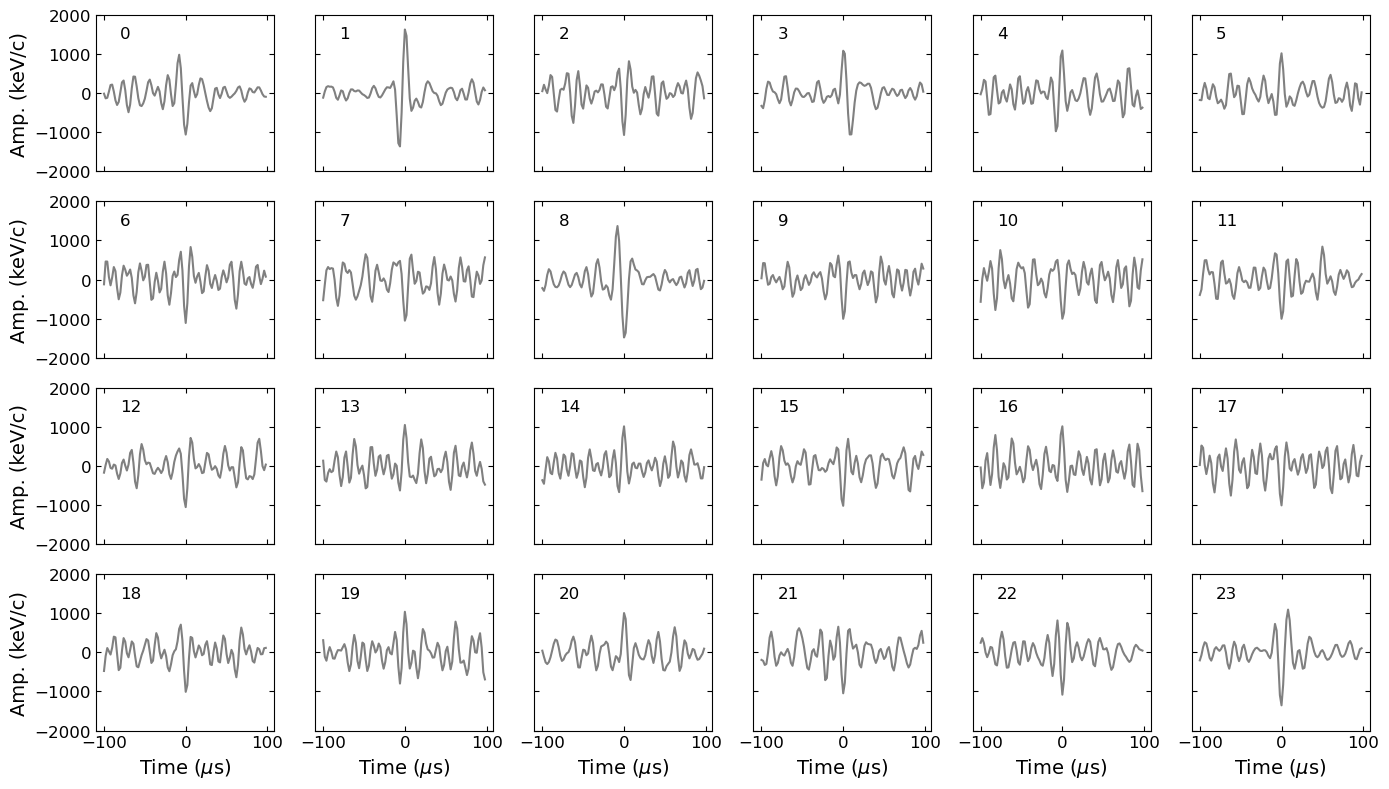

In [247]:
fig, axes = plt.subplots(4, 6, figsize=(14, 8))

searched_idx_in_window = idx_in_window[pulse_window_idx]
for i in range(24):
    ax = axes.flatten()[i]

    _zz_bp = zz_bp_shaped[pulse_window_idx[0][i]]
    _amp, amp_lp, temp = utils.recon_force(dtt, _zz_bp, c_mv=None)

    # idx_pulse = np.argmax(np.abs(amp_lp[100:-50])) + 100
    idx_pulse = searched_idx_in_window[i]

    tt = (np.arange(0, 100) - 50) * 2
    ax.plot(tt, amp_lp[idx_pulse - 50 : idx_pulse + 50] * amp2kev, color='grey')
    ax.text(-80, 1400, f'{i}', fontsize=12)

    if i % 6 != 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('Amp. (keV/c)')
    if i < 18:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Time ($\mu$s)')
    ax.set_ylim(-2000, 2000)

fig.tight_layout()
fig.align_labels()

In [425]:
sphere_0 = 'sphere_20241202'
datasets_0 = ['20241202_8e-8mbar_long',
            '20241204_2e-8mbar_8e_aftercal_long',
            '20241205_2e-8mbar_0e_aftercal_long',
            '20241206_1e-8mbar_0e_aftercal_long',
            '20241207_1e-8mbar_1e_aftercal_long',
            '20241208_1e-8mbar_1e_aftercal_long',
            '20241210_1e-8mbar_8e_alignment1_long',
            '20241210_1e-8mbar_8e_alignment2_long_withdrive',
            '20241210_1e-8mbar_8e_alignment2_long_nodrive',
            '20241211_1e-8mbar_8e_alignment2_long_nodrive',
            '20241212_1e-8mbar_8e_alignment2_long_nodrive',
            '20241213_1e-8mbar_0e_alignment2_long',
            '20241214_1e-8mbar_0e_alignment2_long',
            '20241215_9e-9mbar_0e_alignment2_long',
            '20241216_5e-8mbar_0e_alignment2_long',
            '20241217_6e-8mbar_0e_alignment3_long'
            ]

sphere_1 = 'sphere_20250103'
datasets_1 = ['20250104_4e-8mbar_alignment0_long',
            '20250105_2e-8mbar_alignment0_long',
            '20250106_2e-8mbar_8e_alignment0_long',
            '20250107_1e-8mbar_8e_alignment0_long',
            '20250108_1e-8mbar_8e_alignment0_long',
            '20250109_1e-8mbar_8e_alignment1_long',
            '20250110_1e-8mbar_8e_alignment1_long',
            '20250111_1e-8mbar_8e_alignment1_long',
            '20250112_9e-9mbar_8e_alignment1_long',
            '20250113_5e-8mbar_8e_alignment1_long',
            '20250114_1e-8mbar_1e_alignment1_long',
            '20250115_8e-9mbar_0e_alignment1_long',
            '20250116_8e-9mbar_0e_alignment1_long_wrong_lo',
            '20250117_8e-9mbar_0e_alignment1_long',
            '20250118_8e-9mbar_1e_alignment1_long',
            '20250120_8e-9mbar_1e_alignment1_long_wbackscat',
            '20250121_8e-9mbar_1e_alignment1_long',
            '20250122_8e-9mbar_1e_alignment1_long',
            '20250123_7e-9mbar_1e_alignment1_long',
            '20250124_7e-9mbar_1e_alignment1_long',
            '20250125_7e-9mbar_1e_alignment1_long'    
            ]

In [464]:
data_dir = r'/Users/yuhan/work/nanospheres/data/dm_data_hist_waveform'

pulse_amps_0, pulse_times_0 = [], []
pulse_amps_1, pulse_times_1 = [], []

for i, dataset in enumerate(datasets_0):
    with h5py.File(f'{data_dir}/{sphere_0}/{dataset}_pulse_waveforms.hdf5', 'r') as f:
        pulse_amps_0.append(f['pulses']['pulse_amp'][:])
        pulse_times_0.append(f['pulses']['pulse_time'][:])
        f.close()

for i, dataset in enumerate(datasets_1):
    with h5py.File(f'{data_dir}/{sphere_1}/{dataset}_pulse_waveforms.hdf5', 'r') as f:
        pulse_amps_1.append(f['pulses']['pulse_amp'][:])
        pulse_times_1.append(f['pulses']['pulse_time'][:])
        f.close()

pulse_amps_0 = np.concatenate(pulse_amps_0)
pulse_times_0 = np.concatenate(pulse_times_0)

pulse_amps_1 = np.concatenate(pulse_amps_1)
pulse_times_1 = np.concatenate(pulse_times_1)

Text(400, 3500, 'Sphere 20250103')

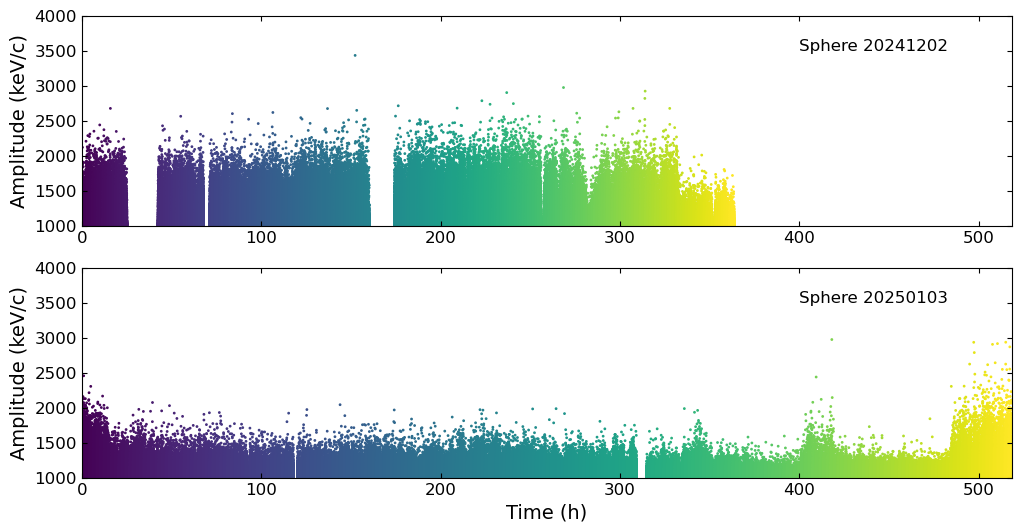

In [427]:
amp2kev_20241202 = 7187.368332843102
amp2kev_20250103 = 7157.624533259538

fig, axes = plt.subplots(2, 1, figsize=(12, 6))

time_hour_0 = (pulse_times_0 - pulse_times_0[0])/3600
time_hour_1 = (pulse_times_1 - pulse_times_1[0])/3600

axes[0].scatter(time_hour_0, np.abs(pulse_amps_0) * amp2kev_20241202, c=time_hour_0, cmap='viridis', s=1)
axes[1].scatter(time_hour_1, np.abs(pulse_amps_1) * amp2kev_20250103, c=time_hour_1, cmap='viridis', s=1)

for ax in axes:
    ax.set_xlim(0, np.max(time_hour_1))
    ax.set_ylim(1000, 4000)
    ax.set_ylabel('Amplitude (keV/c)')

axes[1].set_xlabel('Time (h)')

axes[0].text(400, 3500, 'Sphere 20241202', fontsize=12)
axes[1].text(400, 3500, 'Sphere 20250103', fontsize=12)

#### Estimate Poisson rate in each 1 minute window
Set the cut threshold to be > 12 events / min (Sphere 20241202) and > 3 events / min (Sphere 20250103)

In [466]:
large_pulses_0 = np.abs(pulse_amps_0) * amp2kev_20241202 > 1300
large_pulses_1 = np.abs(pulse_amps_1) * amp2kev_20250103 > 1300

large_pulse_times_0 = (pulse_times_0[large_pulses_0] - pulse_times_0[large_pulses_0][0]) / 60
large_pulse_times_1 = (pulse_times_1[large_pulses_1] - pulse_times_1[large_pulses_1][0]) / 60

bins_time_0 = np.arange(0, np.ceil(large_pulse_times_0.max()), 1)
bins_time_1 = np.arange(0, np.ceil(large_pulse_times_1.max()), 1)

hh_large_pulse_time_0, _ = np.histogram(large_pulse_times_0, bins=bins_time_0)
hh_large_pulse_time_1, _ = np.histogram(large_pulse_times_1, bins=bins_time_1)

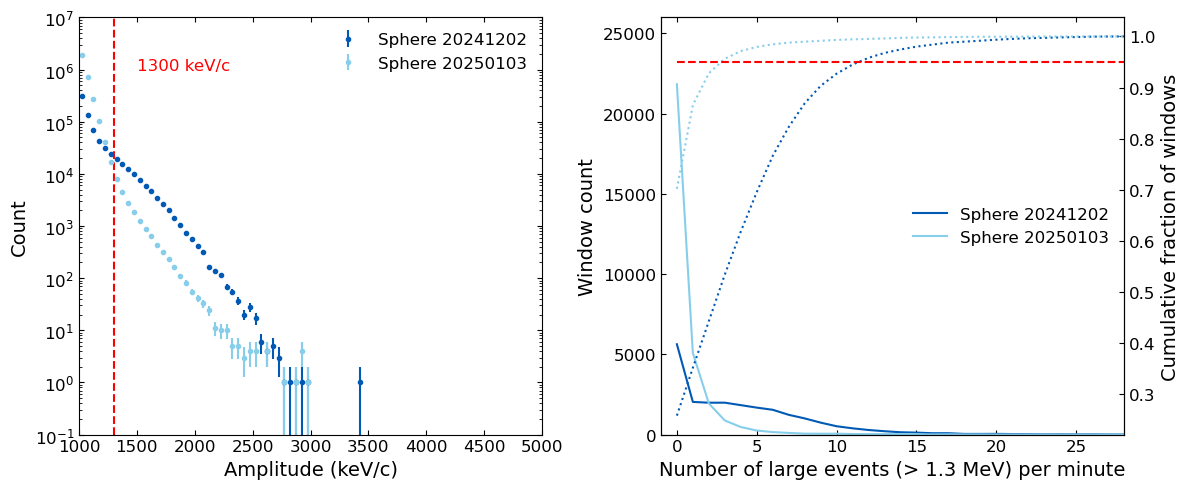

In [529]:
bins = np.arange(0, 10000, 50)  # keV
bc = 0.5 * (bins[:-1] + bins[1:])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = axes[0]
hh_0, _ = np.histogram(np.abs(pulse_amps_0) * amp2kev_20241202, bins=bins)
hh_1, _ = np.histogram(np.abs(pulse_amps_1) * amp2kev_20250103, bins=bins)

ax.errorbar(bc, hh_0, yerr=np.sqrt(hh_0), fmt='.', label='Sphere 20241202', color='#005AB5')
ax.errorbar(bc, hh_1, yerr=np.sqrt(hh_1), fmt='.', label='Sphere 20250103', color='skyblue')

ax.set_xlim(1000, 5000)
ax.set_ylim(1e-1, 1e7)

ax.vlines(1300, 0.1, 1e7, 'r', linestyles='--')
ax.text(1500, 1e6, '1300 keV/c', color='r', fontsize=12)
ax.set_yscale('log')

ax.set_xlabel('Amplitude (keV/c)')
ax.set_ylabel('Count')

ax.legend(frameon=False)

bins_count = np.arange(-0.5, 29.5, 1)
bc = 0.5 * (bins_count[1:] + bins_count[:-1])

count_large_pulse_0, _ = np.histogram(hh_large_pulse_time_0, bins_count)
count_large_pulse_1, _ = np.histogram(hh_large_pulse_time_1, bins_count)

ax = axes[1]
ax.plot(bc, count_large_pulse_0, '#005AB5', label='Sphere 20241202')
ax.plot(bc, count_large_pulse_1, 'skyblue', label='Sphere 20250103')

ax1 = ax.twinx()
ax1.plot(bc, np.cumsum(count_large_pulse_0)/np.sum(count_large_pulse_0), '#005AB5', linestyle=':')
ax1.plot(bc, np.cumsum(count_large_pulse_1)/np.sum(count_large_pulse_1), 'skyblue', linestyle=':')
ax1.hlines(0.95, 0, 30, 'r', linestyle='--')

ax.set_xlim(-1, 28)
ax.set_ylim(0, 26000)

ax.set_xlabel('Number of large events (> 1.3 MeV) per minute')
ax.set_ylabel('Window count')
ax1.set_ylabel('Cumulative fraction of windows')
ax.legend(frameon=False, loc=7)

fig.tight_layout()

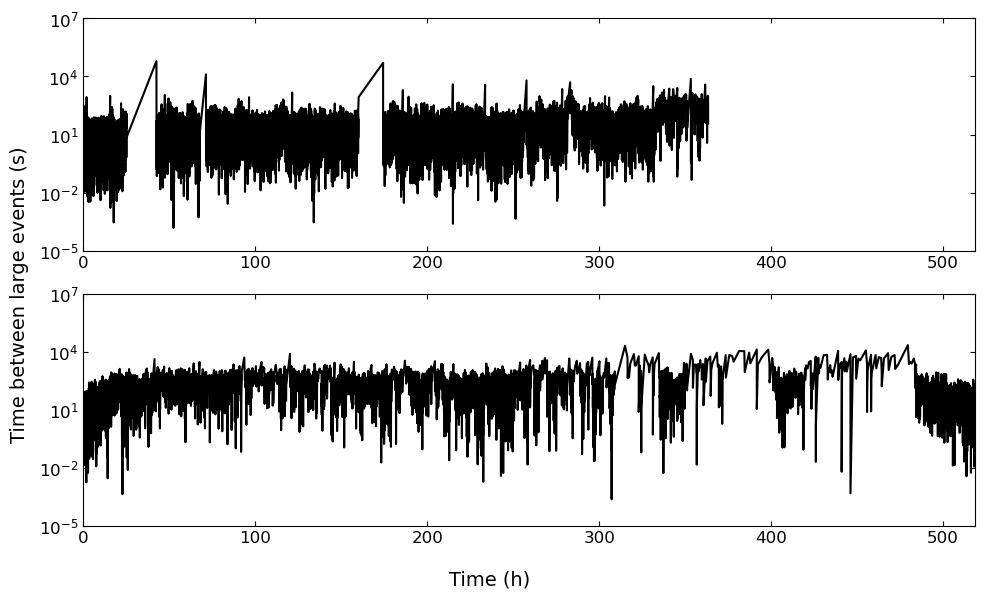

In [457]:
large_pulses_0 = pulse_amps_0 * amp2kev_20241202 > 1300
large_pulses_1 = pulse_amps_1 * amp2kev_20250103 > 1300

pulse_time_diff_0 = np.diff(pulse_times_0[large_pulses_0], prepend=np.nan)
pulse_time_diff_1 = np.diff(pulse_times_1[large_pulses_1], prepend=np.nan)

fig, axes = plt.subplots(2, 1, figsize=(10, 6))

axes[0].plot(time_hour_0[large_pulses_0], pulse_time_diff_0, 'k')
axes[1].plot(time_hour_1[large_pulses_1], pulse_time_diff_1, 'k')

axes[0].set_xlim(0, np.max(time_hour_1))
axes[1].set_xlim(0, np.max(time_hour_1))

for ax in axes:
    ax.set_ylim(1e-5, 1e7)
    ax.set_yscale('log')

fig.supylabel('Time between large events (s)', fontsize=14, )
fig.supxlabel('Time (h)', fontsize=14)

fig.tight_layout()

Take a look at the waveforms of nearby events

In [433]:
idx = 500

f = h5py.File(f'/Volumes/LaCie/dm_data_processed_amp_chisquare/sphere_20250103/20250104_4e-8mbar_alignment0_long/20250104_d_{idx}_processed.hdf5', 'r')
amplitude = f['data_processed']['amplitude'][:]
idx_in_window = f['data_processed']['idx_in_window'][:]
good_detection = f['data_processed']['good_detection'][:]
noise_level_amp = f['data_processed']['noise_level_amp'][:]
chisquare_short = f['data_processed']['chisquare_short'][:]
f.close()

amp_thr = 1500
noise_thr = 400
chi2_thr_short = 150

# 10 ms windows with good detection and noise properties
good_noise = (noise_level_amp * amp2kev) < noise_thr
good_det_noise = np.logical_and(good_detection, good_noise)

amplitude_short = np.copy(amplitude)
bad_chi2_short = (chisquare_short > chi2_thr_short)
amplitude_short[bad_chi2_short] = np.nan

pulse_window_idx = np.nonzero(np.logical_and(np.abs(amplitude_short) * amp2kev > amp_thr, np.tile(good_det_noise, (194, 1)).T))

In [434]:
indices = [3, 8, 9, 10, 13]
# indices = [96,  99, 103, 106, 116]

amps_all = []
for idx in indices:
    window_length = 5000
    f = h5py.File(f'/Volumes/LaCie/dm_data/sphere_20250103/20250104_4e-8mbar_alignment0_long/20250104_d_{idx}.hdf5', 'r')

    dtt = f['data'].attrs['delta_t']
    fs = int(np.ceil(1 / dtt))   # Sampling rate at Hz
    zz = f['data']['channel_d'][:] * f['data']['channel_d'].attrs['adc2mv'] / 1e3  # Signal in V

    zz_bp = utils.bandpass_filtered(zz, fs, 30000, 80000)

    zz_shaped = np.reshape(zz, (int(zz.size / window_length), window_length))
    zz_bp_shaped = np.reshape(zz_bp, (int(zz_bp.size / window_length), window_length))

    amps = np.empty((6000, 5000))
    for i, _zz_bp in enumerate(zz_bp_shaped):
        _amp, amp_lp, temp = utils.recon_force(dtt, _zz_bp, c_mv=None)
        amps[i] = amp_lp
        amps[i][:100] = np.nan
        amps[i][-50:] = np.nan

    amps_all.append(amps)

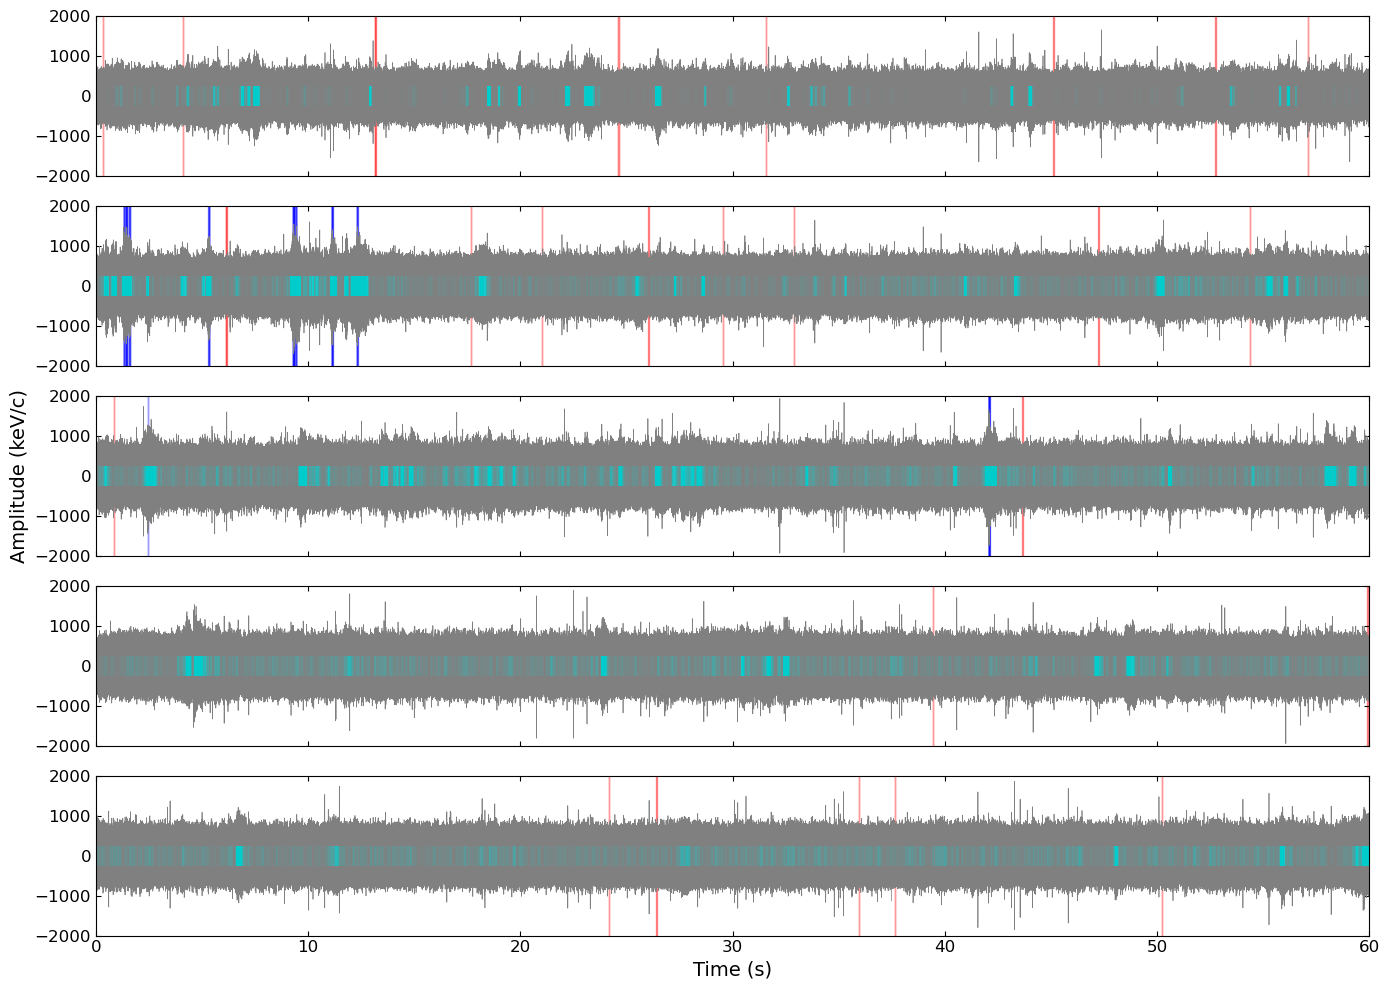

In [36]:
fig, axes = plt.subplots(5, 1, figsize=(14, 10))

noise_thr = 400
chi2_thr_short = 150
tt = np.arange(0, amps_all[0].size) * 2e-6

for i, idx_file in enumerate(indices):
    f = h5py.File(f'/Volumes/LaCie/dm_data_processed_amp_chisquare/sphere_20250103/20250104_4e-8mbar_alignment0_long/20250104_d_{idx_file}_processed.hdf5', 'r')
    # amplitude = f['data_processed']['amplitude'][:]
    idx_in_window = f['data_processed']['idx_in_window'][:]
    good_detection = f['data_processed']['good_detection'][:]
    noise_level_amp = f['data_processed']['noise_level_amp'][:]
    chisquare_short = f['data_processed']['chisquare_short'][:]
    f.close()

    bad_detection_windows = np.nonzero(~good_detection)[0]
    bad_noise_windows = np.nonzero((noise_level_amp * amp2kev) > noise_thr)[0]

    axes[i].plot(tt, np.concatenate(amps_all[i]) * amp2kev, 'grey', linewidth=0.5)

    for bad_det_win in bad_detection_windows:
        axes[i].fill_betweenx(np.linspace(-2500, 2500, 50), 5000*2e-6*bad_det_win, 5000*2e-6*(bad_det_win+1), color='r', alpha=0.4)
    for bad_noise_win in bad_noise_windows:
        axes[i].fill_betweenx(np.linspace(-2500, 2500, 50), 5000*2e-6*bad_noise_win, 5000*2e-6*(bad_noise_win+1), color='b', alpha=0.4)

    bad_chi2_short = (chisquare_short > chi2_thr_short)
    bad_chi2_pulse_time = 2e-6 * (5000 * np.nonzero(chisquare_short > chi2_thr_short)[0] + idx_in_window[chisquare_short > chi2_thr_short])
    axes[i].vlines(bad_chi2_pulse_time, -250, 250, color='cyan', alpha=0.5, linewidth=0.05)

    axes[i].set_ylim(-2000, 2000)
    axes[i].set_xlim(0, 60)

    if i != 4:
        axes[i].set_xticklabels([])

axes[4].set_xlabel('Time (s)')
axes[2].set_ylabel('Amplitude (keV/c)')

fig.tight_layout()

In [56]:
indices = [3, 8]

amps_all = []
for idx in indices:
    window_length = 5000
    f = h5py.File(f'/Volumes/LaCie/dm_data/sphere_20250103/20250111_1e-8mbar_8e_alignment1_long/20250111_d_{idx}.hdf5', 'r')

    dtt = f['data'].attrs['delta_t']
    fs = int(np.ceil(1 / dtt))   # Sampling rate at Hz
    zz = f['data']['channel_d'][:] * f['data']['channel_d'].attrs['adc2mv'] / 1e3  # Signal in V

    zz_bp = utils.bandpass_filtered(zz, fs, 30000, 80000)

    zz_shaped = np.reshape(zz, (int(zz.size / window_length), window_length))
    zz_bp_shaped = np.reshape(zz_bp, (int(zz_bp.size / window_length), window_length))

    amps = np.empty((6000, 5000))
    for i, _zz_bp in enumerate(zz_bp_shaped):
        _amp, amp_lp, temp = utils.recon_force(dtt, _zz_bp, c_mv=None)
        amps[i] = amp_lp
        amps[i][:100] = np.nan
        amps[i][-50:] = np.nan

    amps_all.append(amps)

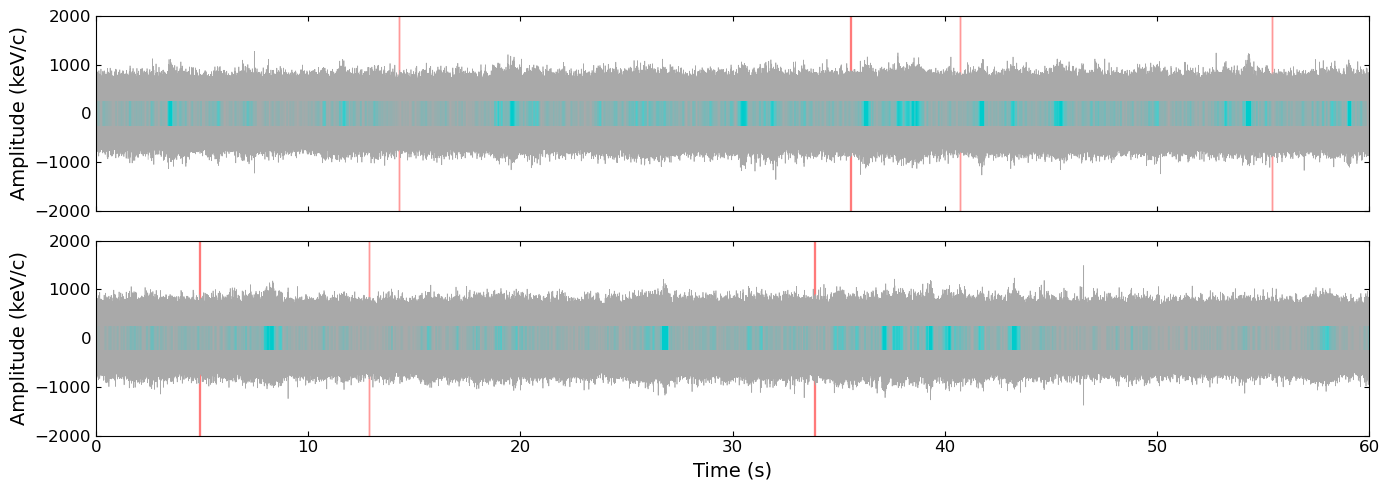

In [63]:
fig, axes = plt.subplots(2, 1, figsize=(14, 5))

noise_thr = 400
chi2_thr_short = 150
tt = np.arange(0, amps_all[0].size) * 2e-6

for i, idx_file in enumerate(indices):
    f = h5py.File(f'/Volumes/LaCie/dm_data_processed_amp_chisquare/sphere_20250103/20250111_1e-8mbar_8e_alignment1_long/20250111_d_{idx_file}_processed.hdf5', 'r')
    # amplitude = f['data_processed']['amplitude'][:]
    idx_in_window = f['data_processed']['idx_in_window'][:]
    good_detection = f['data_processed']['good_detection'][:]
    noise_level_amp = f['data_processed']['noise_level_amp'][:]
    chisquare_short = f['data_processed']['chisquare_short'][:]
    f.close()

    bad_detection_windows = np.nonzero(~good_detection)[0]
    bad_noise_windows = np.nonzero((noise_level_amp * amp2kev) > noise_thr)[0]

    axes[i].plot(tt, np.concatenate(amps_all[i]) * amp2kev, 'darkgrey', linewidth=0.5)

    for bad_det_win in bad_detection_windows:
        axes[i].fill_betweenx(np.linspace(-2500, 2500, 50), 5000*2e-6*bad_det_win, 5000*2e-6*(bad_det_win+1), color='r', alpha=0.4)
    for bad_noise_win in bad_noise_windows:
        axes[i].fill_betweenx(np.linspace(-2500, 2500, 50), 5000*2e-6*bad_noise_win, 5000*2e-6*(bad_noise_win+1), color='b', alpha=0.4)

    bad_chi2_short = (chisquare_short > chi2_thr_short)
    bad_chi2_pulse_time = 2e-6 * (5000 * np.nonzero(chisquare_short > chi2_thr_short)[0] + idx_in_window[chisquare_short > chi2_thr_short])
    axes[i].vlines(bad_chi2_pulse_time, -250, 250, color='cyan', alpha=0.5, linewidth=0.05)

    axes[i].set_ylim(-2000, 2000)
    axes[i].set_xlim(0, 60)

    if i != 1:
        axes[i].set_xticklabels([])

axes[1].set_xlabel('Time (s)')
for ax in axes:
    ax.set_ylabel('Amplitude (keV/c)')

fig.tight_layout()

1491.994111362699


Text(0, 0.5, 'Recon. amp. (keV/c)')

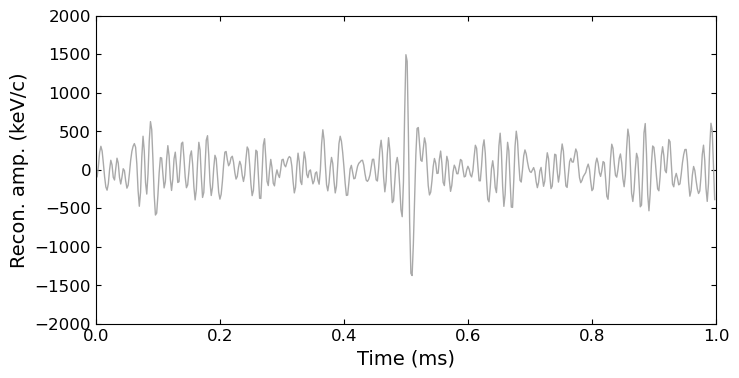

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

idx_max = np.argmax(np.nan_to_num(np.abs(amps_all[1])))
ax.plot(np.arange(0, 500)*2e-3, np.concatenate(amps_all[1])[idx_max-250:idx_max+250]*amp2kev, 'darkgrey', linewidth=1)
print(np.concatenate(amps_all[1])[idx_max] * amp2kev)

ax.set_xlim(0, 1)
ax.set_ylim(-2000, 2000)

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Recon. amp. (keV/c)')

## Final histograms after all cuts

In [531]:
data_dir = r'/Users/yuhan/work/nanospheres/data/dm_data_hist_waveform'

hhs_all_0, hhs_det_0, hhs_det_noise_0, hhs_det_noise_chi2_short_0 = [], [], [], []
hhs_all_1, hhs_det_1, hhs_det_noise_1, hhs_det_noise_chi2_short_1 = [], [], [], []

for i, dataset in enumerate(datasets_0):
    with h5py.File(f'{data_dir}/{sphere_0}/{dataset}_summed_histograms.hdf5', 'r') as f:
        hhs_all_0.append(f['summed_histograms']['hh_all'][:])
        hhs_det_0.append(f['summed_histograms']['hh_det'][:])
        hhs_det_noise_0.append(f['summed_histograms']['hh_det_noise'][:])
        hhs_det_noise_chi2_short_0.append(f['summed_histograms']['hh_det_noise_chi2_short'][:])

        f.close()

for i, dataset in enumerate(datasets_1):
    with h5py.File(f'{data_dir}/{sphere_1}/{dataset}_summed_histograms.hdf5', 'r') as f:
        hhs_all_1.append(f['summed_histograms']['hh_all'][:])
        hhs_det_1.append(f['summed_histograms']['hh_det'][:])
        hhs_det_noise_1.append(f['summed_histograms']['hh_det_noise'][:])
        hhs_det_noise_chi2_short_1.append(f['summed_histograms']['hh_det_noise_chi2_short'][:])

        f.close()

In [532]:
def get_final_hist(bc, hhs_det_noise_chi2, threshold_kev, threshold_count):
    ret = np.zeros(bc.size, dtype=np.int64)

    for hhs in hhs_det_noise_chi2:
        for hh in hhs:
            if np.sum(hh[bc > threshold_kev]) > threshold_count:
                continue
            else:
                ret += hh

    return ret

In [541]:
bins = np.arange(0, 10000, 50)  # keV
bc = 0.5 * (bins[:-1] + bins[1:])

hhs_final_0 = get_final_hist(bc, hhs_det_noise_chi2_short_0, 1300, 12)
hhs_final_1 = get_final_hist(bc, hhs_det_noise_chi2_short_1, 1300, 3)

In [542]:
n_window_all_0 = np.sum(np.sum(np.asarray([ np.sum(hhs_all_0[i], axis=0) for i in range(len(datasets_0))])))
n_window_det_0 = np.sum(np.sum(np.asarray([ np.sum(hhs_det_0[i], axis=0) for i in range(len(datasets_0))])))
n_window_det_noise_0 = np.sum(np.sum(np.asarray([ np.sum(hhs_det_noise_0[i], axis=0) for i in range(len(datasets_0))])))
n_window_det_noise_chi2_short_0 = np.sum(np.sum(np.asarray([ np.sum(hhs_det_noise_chi2_short_0[i], axis=0) for i in range(len(datasets_0))])))

print('Sphere 20241202\n===============')
print(f'Detection cut: {(n_window_all_0 - n_window_det_0) / n_window_all_0 * 100:.2f} %')
print(f'Noise level cut: {(n_window_det_0 - n_window_det_noise_0) / n_window_det_0 * 100:.2f} %')
print(f'Pulse shape cut: {(n_window_det_noise_0 - n_window_det_noise_chi2_short_0) / n_window_det_noise_0 * 100:.2f} % (event level)')
print(f'Anti-coincidence cut: {(n_window_det_noise_chi2_short_0 - np.sum(hhs_final_0)) / n_window_det_noise_chi2_short_0 * 100:.2f} %')


Sphere 20241202
Detection cut: 5.35 %
Noise level cut: 0.62 %
Pulse shape cut: 1.51 % (event level)
Anti-coincidence cut: 5.69 %


In [543]:
n_window_all_1 = np.sum(np.sum(np.asarray([ np.sum(hhs_all_1[i], axis=0) for i in range(len(datasets_1))])))
n_window_det_1 = np.sum(np.sum(np.asarray([ np.sum(hhs_det_1[i], axis=0) for i in range(len(datasets_1))])))
n_window_det_noise_1 = np.sum(np.sum(np.asarray([ np.sum(hhs_det_noise_1[i], axis=0) for i in range(len(datasets_1))])))
n_window_det_noise_chi2_short_1 = np.sum(np.sum(np.asarray([ np.sum(hhs_det_noise_chi2_short_1[i], axis=0) for i in range(len(datasets_1))])))

print('Sphere 20250103\n===============')
print(f'Detection cut: {(n_window_all_1 - n_window_det_1) / n_window_all_1 * 100:.2f} %')
print(f'Noise level cut: {(n_window_det_1 - n_window_det_noise_1) / n_window_det_1 * 100:.2f} %')
print(f'Pulse shape cut: {(n_window_det_noise_1 - n_window_det_noise_chi2_short_1) / n_window_det_noise_1 * 100:.2f} % (event level)')
print(f'Anti-coincidence cut: {(n_window_det_noise_chi2_short_1 - np.sum(hhs_final_1)) / n_window_det_noise_chi2_short_1 * 100:.2f} %')


Sphere 20250103
Detection cut: 2.31 %
Noise level cut: 1.27 %
Pulse shape cut: 2.11 % (event level)
Anti-coincidence cut: 4.87 %


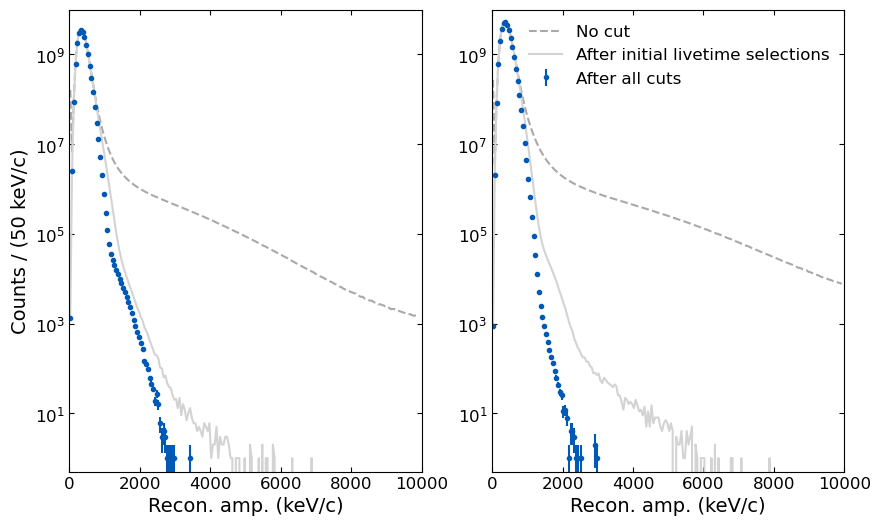

In [561]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

ax = axes[0]
ax.plot(bc, np.sum(np.asarray([ np.sum(hhs_all_0[i], axis=0) for i in range(len(datasets_0))]), axis=0), 'darkgrey', linestyle='--')
ax.plot(bc, np.sum(np.asarray([ np.sum(hhs_det_noise_0[i], axis=0) for i in range(len(datasets_0))]), axis=0), 'lightgrey', linestyle='-')
# ax.plot(bc, np.sum(np.asarray([ np.sum(hhs_det_noise_chi2_short_0[i], axis=0) for i in range(len(datasets_0))]), axis=0), 'skyblue', linestyle='--')
ax.errorbar(bc, hhs_final_0, yerr=np.sqrt(hhs_final_0), fmt='.', color='#005AB5')

ax.set_ylabel('Counts / (50 keV/c)')

ax = axes[1]
ax.plot(bc, np.sum(np.asarray([ np.sum(hhs_all_1[i], axis=0) for i in range(len(datasets_1))]), axis=0), 'darkgrey', linestyle='--', label='No cut')
ax.plot(bc, np.sum(np.asarray([ np.sum(hhs_det_noise_1[i], axis=0) for i in range(len(datasets_1))]), axis=0), 'lightgrey', linestyle='-', label='After initial livetime selections')
# ax.plot(bc, np.sum(np.asarray([ np.sum(hhs_det_noise_chi2_short_1[i], axis=0) for i in range(len(datasets_1))]), axis=0), 'skyblue', '--', label='Pulse shape cut')
ax.errorbar(bc, hhs_final_1, yerr=np.sqrt(hhs_final_1), fmt='.', color='#005AB5', label='After all cuts')
ax.legend(frameon=False)

for ax in axes:
    ax.set_xlim(0, 10000)
    ax.set_ylim(5e-1, 1e10)
    ax.set_yscale('log')
    ax.set_xlabel('Recon. amp. (keV/c)')

In [562]:
outfile_name = 'sphere_20241202_recon_all.h5py'
out_dir = r'/Users/yuhan/work/nanospheres/dm_nanospheres/data_processed/sphere_data'

with h5py.File(os.path.join(out_dir, outfile_name), 'w') as fout:
    g = fout.create_group('recon_data_all')
    d = g.create_dataset('bc', data=bc, dtype=np.float64)
    d.attrs['unit'] = 'keV'

    d = g.create_dataset('hist_all', data=(hhs_final_0), dtype=np.int64)
    d.attrs['unit'] = 'count/50keV'

    fout.close()

outfile_name = 'sphere_20250103_recon_all.h5py'
out_dir = r'/Users/yuhan/work/nanospheres/dm_nanospheres/data_processed/sphere_data'

with h5py.File(os.path.join(out_dir, outfile_name), 'w') as fout:
    g = fout.create_group('recon_data_all')
    d = g.create_dataset('bc', data=bc, dtype=np.float64)
    d.attrs['unit'] = 'keV'

    d = g.create_dataset('hist_all', data=(hhs_final_1), dtype=np.int64)
    d.attrs['unit'] = 'count/50keV'

    fout.close()



## Background study (to finish)

<>:15: SyntaxWarning: invalid escape sequence '\p'
<>:16: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:15: SyntaxWarning: invalid escape sequence '\p'
<>:16: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\p'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_2135/2859600628.py:15: SyntaxWarning: invalid escape sequence '\p'
  axes[1].plot(bc, rates[15][-1], '-', color=colors[7], label=f'($8\pm4) \\times 10^{{-9}}$ mbar', alpha=1)
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_2135/2859600628.py:16: SyntaxWarning: invalid escape sequence '\p'
  axes[1].plot(bc, rates[2][-1], '-', color=colors[2], label=f'($2\pm1) \\times 10^{{-8}}$ mbar', alpha=0.8)
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_2135/2859600628.py:17: SyntaxWarning: invalid escape sequence '\p'
  axes[1].plot(bc, rates[6][-1], '-', color=colors[3], label=f'($5\pm3) \\times 10^{{-8}}$ mbar', a

NameError: name 'rates' is not defined

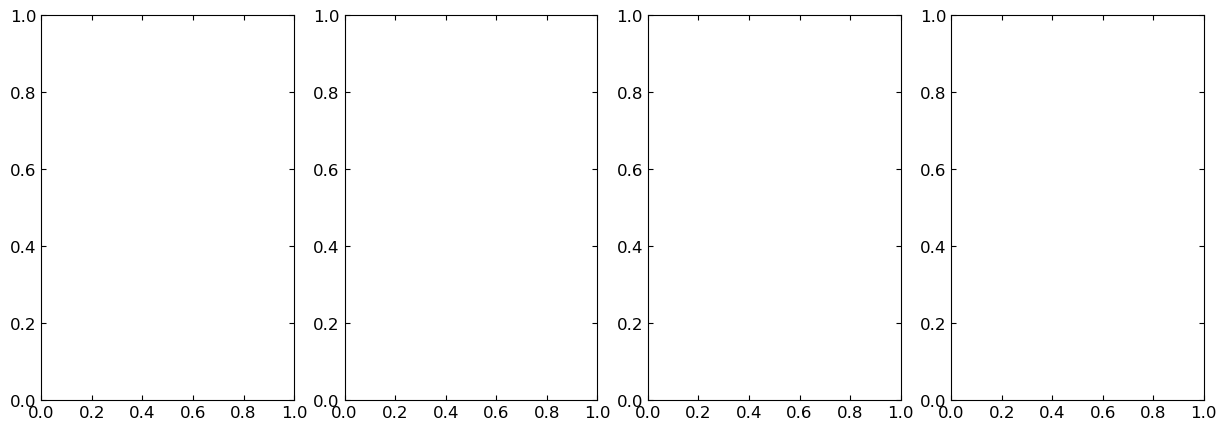

In [560]:
import matplotlib
colors = plt.colormaps.get_cmap('tab20b').resampled(10).colors
colors_day = [matplotlib.colors.rgb2hex(plt.colormaps.get_cmap('RdYlBu')(i)) for i in np.linspace(0, 1, 21)]

fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i in range(21):
    if i == 0:
        axes[0].plot(bc, rates[i][-1], '-', color=colors_day[i], alpha=0.5, linewidth=1.5, label='Day 1 (excluded from analysis)')
    if i == 20:
        axes[0].plot(bc, rates[i][-1], '-', color=colors_day[i], alpha=0.5, linewidth=1.5, label='Day 21')
    else:
        axes[0].plot(bc, rates[i][-1], '-', color=colors_day[i], alpha=0.5, linewidth=1.5)

axes[1].plot(bc, rates[15][-1], '-', color=colors[7], label=f'($8\pm4) \\times 10^{{-9}}$ mbar', alpha=1)
axes[1].plot(bc, rates[2][-1], '-', color=colors[2], label=f'($2\pm1) \\times 10^{{-8}}$ mbar', alpha=0.8)
axes[1].plot(bc, rates[6][-1], '-', color=colors[3], label=f'($5\pm3) \\times 10^{{-8}}$ mbar', alpha=0.8)

axes[2].plot(bc, rates[12][-1], '-', color=colors[4], label=f'0e charge', alpha=1)
axes[2].plot(bc, rates[15][-1], '-', color=colors[7], label=f'-1e charge', alpha=0.8)
axes[2].plot(bc, rates[7][-1], '-', color=colors[5], label=f'-8e charge', alpha=0.8)

axes[3].plot(bc, rates_other[0][-1], '-', color='grey', label=f'Sphere 20241202', alpha=0.8)
axes[3].plot(bc, rates_other[1][-1], '-', color='silver', label=f'Sphere 20241221', alpha=0.8)
axes[3].plot(bc, rates_other[2][-1], '-', color='darkseagreen', label=f'Sphere 20241226', alpha=0.8)
axes[3].plot(bc, rates[15][-1], '-', color=colors[7], label=f'Sphere 20250103', alpha=1)

for ax in axes.flatten():
    ax.legend(frameon=False, fontsize=10, loc='upper right')
    ax.set_yscale('log')
    ax.minorticks_on()

    ax.set_xlim(0, 8000)
    ax.set_ylim(1e-8, 1000)

fig.supxlabel('Reconstructed amplitude (keV/c)', fontsize=14)
fig.supylabel('Differential rate (Hz/keV/c)', fontsize=14)
fig.tight_layout()

## Old reconstruction

In [ ]:
def read_sphere_data(sphere):
    # data_dir = '/home/yt388/microspheres/dm_nanospheres/data_processed'
    data_dir = r'/Users/yuhan/work/nanospheres/dm_nanospheres/data_processed'

    file = f'{data_dir}/sphere_data/{sphere}_recon_all_w_nocut.h5py'
    with h5py.File(file, 'r') as fout:
        g = fout['recon_data_all']

        hists, n_windows, scalings, rates, rate_errs = [], [], [], [], []
        for i in range(4):
            hists.append(g[f'hist_{i}'][:])
            n_windows.append(g[f'hist_{i}'].attrs['n_windows'])
            scalings.append(g[f'hist_{i}'].attrs['scaling'])

            rates.append(g[f'rate_hist_{i}'][:])
            rate_errs.append(g[f'rate_hist_err_{i}'][:])
        bc = g['bc'][:]

        fout.close()

    return bc, hists, n_windows, scalings, rates, rate_errs
    

In [ ]:
bc_0, hists_0, n_windows_0, scalings_0, rates_0, rate_errs_0 = read_sphere_data('sphere_20241202')
bc_1, hists_1, n_windows_1, scalings_1, rates_1, rate_errs_1 = read_sphere_data('sphere_20250103')

In [ ]:
print(f'Cut percentage (Sphere 20241202; DQ, NL, PS): {-1 * np.diff(np.asarray(n_windows_0)) / n_windows_0[0] * 100}')
print(f'Cut percentage (Sphere 20250103; DQ, NL, PS): {-1 * np.diff(np.asarray(n_windows_1)) / n_windows_1[0] * 100}')

Cut percentage (Sphere 20241202; DQ, NL, PS): [7.04848477e+00 6.40000539e-01 5.58130344e-03]
Cut percentage (Sphere 20250103; DQ, NL, PS): [3.27918567 1.41467842 0.011878  ]


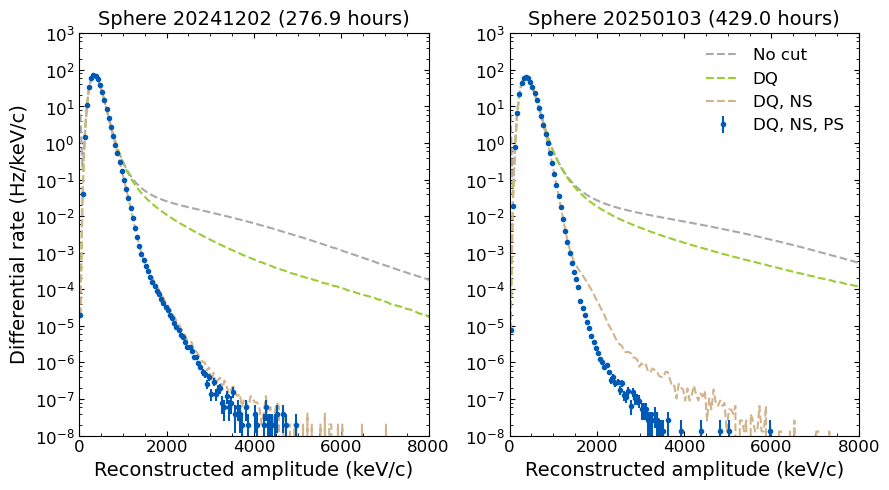

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5))

ax = axes[0]
ax.plot(bc_0, rates_0[0], '--', alpha=1, color='darkgrey')
ax.plot(bc_0, rates_0[1], '--', alpha=1, color='yellowgreen')
ax.plot(bc_0, rates_0[2], '--', alpha=1, color='tan')
ax.errorbar(bc_0, rates_0[3], yerr=rate_errs_0[3], fmt='.', color='#005AB5', alpha=1)

ax.set_title('Sphere 20241202 (276.9 hours)')
ax.set_xlabel('Reconstructed amplitude (keV/c)')
ax.set_ylabel('Differential rate (Hz/keV/c)')

ax = axes[1]
ax.plot(bc_1, rates_1[0], '--', alpha=1, label='No cut', color='darkgrey')
ax.plot(bc_1, rates_1[1], '--', alpha=1, label='DQ', color='yellowgreen')
ax.plot(bc_1, rates_1[2], '--', alpha=1, label='DQ, NS', color='tan')
ax.errorbar(bc_1, rates_1[3], yerr=rate_errs_1[3], fmt='.', color='#005AB5', alpha=1, label='DQ, NS, PS')

ax.set_title('Sphere 20250103 (429.0 hours)')
ax.set_xlabel('Reconstructed amplitude (keV/c)')
ax.legend(frameon=False)

for ax in axes:
    ax.set_yscale('log')
    # ax.set_xscale('log')

    ax.set_xlim(0, 8000)
    ax.set_ylim(1e-8, 1000)

    ax.set_yticks(np.logspace(-8, 3, 12))
    locmin = LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=15)
    ax.xaxis.set_minor_locator(MultipleLocator(500))
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(NullFormatter())

fig.tight_layout()